In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import warnings; warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sympy import symbols

import sys; sys.path.append('../')
from PDE_FIND import *

import sys; sys.path.append('../../parametric-discovery/')
from best_subset import *
from frols import frols
from p_linear_regression import PLinearRegression
from r_pca import R_pca
from pde_diff_new import RPCA
from RobustPCA.rpca import RobustPCA

import scipy.io as sio
from scipy.signal import savgol_filter
import itertools

from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression as SkLinearRegression
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from abess.linear import LinearRegression
from bess import PdasLm
import pysindy as ps

from tqdm import trange
from os.path import join as join_path
FIGURE_EXPORT_PATH = "/Users/pongpisit/Documents/figure_export/"

np.random.seed(100)

Populating the interactive namespace from numpy and matplotlib
Sklearn's version: 1.0.2


In [2]:
def check_percent(bic_scores, complexities):
    slope = (bic_scores[1:]-bic_scores[:-1])/(complexities[1:]-complexities[:-1])
    slope_index = np.argmin(slope)
    percent_improve = 100*np.abs(bic_scores[slope_index+1]-bic_scores[slope_index])/np.abs(bic_scores[slope_index])
    percent_from_1 = 100*np.abs(bic_scores[slope_index+1]-bic_scores[0])/np.abs(bic_scores[0])
    return slope_index+1, percent_improve, percent_from_1

def percent_coeff(pred, ground):
    return 100*(np.abs(pred-ground)/np.abs(ground))

In [3]:
n = 128
data = sio.loadmat(f"../Datasets/reaction_diffusion_3d_{n}.mat")
u_sol = real(data['usol'])
v_sol = real(data['vsol'])
x = real(data['x'][0])
y = real(data['y'][0])
z = real(data['z'][0])
t = real(data['t'][0])

del data

dt = t[1] - t[0]
dx = x[1] - x[0]
dy = y[1] - y[0]
dz = z[1] - z[0]
# For WeakPDELibrary
ground_indices_u = (0, 1, 5, 9, 15, 23)
ground_coeff_u = np.array([0.014, -0.014, -1.000, 0.020, 0.020, 0.020])
ground_indices_v = (2, 5, 10, 16, 24)
ground_coeff_v = np.array([-0.067, 1.0, 0.01, 0.01, 0.01])

x, y, z, t

(array([-1.25      , -1.23046875, -1.2109375 , -1.19140625, -1.171875  ,
        -1.15234375, -1.1328125 , -1.11328125, -1.09375   , -1.07421875,
        -1.0546875 , -1.03515625, -1.015625  , -0.99609375, -0.9765625 ,
        -0.95703125, -0.9375    , -0.91796875, -0.8984375 , -0.87890625,
        -0.859375  , -0.83984375, -0.8203125 , -0.80078125, -0.78125   ,
        -0.76171875, -0.7421875 , -0.72265625, -0.703125  , -0.68359375,
        -0.6640625 , -0.64453125, -0.625     , -0.60546875, -0.5859375 ,
        -0.56640625, -0.546875  , -0.52734375, -0.5078125 , -0.48828125,
        -0.46875   , -0.44921875, -0.4296875 , -0.41015625, -0.390625  ,
        -0.37109375, -0.3515625 , -0.33203125, -0.3125    , -0.29296875,
        -0.2734375 , -0.25390625, -0.234375  , -0.21484375, -0.1953125 ,
        -0.17578125, -0.15625   , -0.13671875, -0.1171875 , -0.09765625,
        -0.078125  , -0.05859375, -0.0390625 , -0.01953125,  0.        ,
         0.01953125,  0.0390625 ,  0.05859375,  0.0

In [4]:
time = t
u = np.zeros((n, n, n, len(time), 2))
u[:, :, :, :, 0] = u_sol
u[:, :, :, :, 1] = v_sol
# u_dot = ps.FiniteDifference(axis=3)._differentiate(u, dt)

# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [
    lambda x: x,
    lambda x: x * x * x,
    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]

# Need to define the 2D spatial grid before calling the library
X, Y, Z, T = np.meshgrid(x, y, z, time, indexing="ij")
spatiotemporal_grid = np.asarray([X, Y, Z, T])
spatiotemporal_grid = np.transpose(spatiotemporal_grid, axes=[1, 2, 3, 4, 0])
weak_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=spatiotemporal_grid,
    is_uniform=True,
    include_interaction=False,
    include_bias=True,
    periodic=True,
    K=10000,
    cache=True
)

In [5]:
np.random.seed(100)
noise_lvs = [0, 0.04, 0.1]
noise_lv = noise_lvs[-1]
domain_noise = 0.01*np.abs(noise_lv)*np.std(u)*np.random.randn(*u.shape)
u = u + domain_noise
# np.save("u_noise1e-1.npy", u)

In [6]:
denoise = True
if denoise: 
    u = np.load("u_noise1e-1_denoised.npy")

In [7]:
include_sr3 = True
# Fit the 3D reaction-diffusion equation
optimizer = ps.SR3(threshold=1e-5, normalize_columns=True, max_iter=100)
model = ps.SINDy(feature_library=weak_lib, optimizer=optimizer, cache=True)
model.fit(u, ensemble=False, library_ensemble=True)
model.print()

(x0)' = 0.014 1 + -0.014 x0 + -1.000 x0x1x1 + 0.020 x0_33 + 0.020 x0_22 + 0.020 x0_11
(x1)' = -0.067 x1 + 1.000 x0x1x1 + 0.010 x1_33 + 0.010 x1_22 + 0.010 x1_11


In [8]:
_, ensemble_indices_u = model.validate_coef_list(target_index=0, criterion='bic')[0]
ensemble_indices_u

hasattr threshold in optimizer...
x0_t = (0.013997 +0.000000i)1
    + (-0.013965 +0.000000i)x0
    + (-1.000266 +0.000000i)x0x1x1
    + (0.019998 +0.000000i)x0_33
    + (0.020000 +0.000000i)x0_22
    + (0.020004 +0.000000i)x0_11
   


(0, 1, 5, 9, 15, 23)

In [9]:
_, ensemble_indices_v = model.validate_coef_list(target_index=1, criterion='bic')[0]
ensemble_indices_v

hasattr threshold in optimizer...
x1_t = (-0.067002 +0.000000i)x1
    + (1.000066 +0.000000i)x0x1x1
    + (0.009997 +0.000000i)x1_33
    + (0.009999 +0.000000i)x1_22
    + (0.010000 +0.000000i)x1_11
   


(2, 5, 10, 16, 24)

In [10]:
# pub 32 v
# ({(0, 1, 2, 4, 6, 9, 10, 15, 16, 22, 23, 24),
#   (0, 1, 5, 9, 15, 23),
#   (0, 1, 5, 10, 15, 23),
#   (0, 3, 5, 9, 15, 23)},
#  {(0, 1, 2, 3, 4, 5, 9, 10, 17, 21, 24),
#   (0, 1, 2, 4, 6, 10, 15, 16, 22, 23, 24),
#   (1, 2, 3, 4, 5, 6, 10, 15, 16, 21, 22),
#   (1, 4, 5, 6, 10, 16, 22, 24),
#   (2, 5, 10, 16, 24)})

sr3_u = set()
sr3_u.add(ensemble_indices_u)
for i in range(len(model.get_coef_list())):
    sr3_u.add(nonz(model.get_coef_list()[i][0]))
sr3_v = set()
sr3_v.add(ensemble_indices_v)
for i in range(len(model.get_coef_list())):
    sr3_v.add(nonz(model.get_coef_list()[i][1]))
sr3_u, sr3_v

({(0, 1, 5, 9, 15, 23),
  (0, 3, 5, 9, 15, 23),
  (1, 2, 3, 4, 5, 6, 9, 10, 15, 16, 21, 22, 23, 24)},
 {(0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 15, 16, 17, 20, 21, 22, 23),
  (1, 2, 5, 6, 9, 16, 23, 24),
  (1, 3, 4, 5, 6, 9, 10, 15, 16, 22, 23, 24),
  (2, 5, 10, 16, 24)})

In [12]:
X_pre, y_pre = model.feature_library.cached_xp_full[0], model.cached_x_dot
X_pre = np.load("./IPI_output_files/X_pre_noise1e-1_denoised.npy")
y_pre = np.load("./IPI_output_files/y_pre_noise1e-1_denoised.npy")

In [13]:
max_complexity = 12; target_index = 1

In [14]:
# pub 32 v
# {(2,), (2, 5, 10, 16, 24), (2, 5, 16, 24), (5, 16, 24)}

nor_axis = None
Xbnb = X_pre.copy()
if nor_axis is not None: Xbnb = normalize(Xbnb, axis=nor_axis)

thres = 1e-4
bnb_sols = bnb(Xbnb, y_pre[:, target_index:target_index+1].ravel(), max_nonzeros=max_complexity, 
               lam=1e-2, threshold=thres, normalize=True, corrected_coefficients=True)
bnb_feature_hierarchy = set([tuple(np.nonzero(bnb_sols[:, i:i+1].flatten())[0].tolist()) 
                             for i in range(bnb_sols.shape[1])])
bnb_feature_hierarchy

{(2,), (2, 5, 10, 16, 24), (2, 5, 16, 24), (5, 16, 24)}

In [15]:
nor_axis = None
Xfrols = X_pre.copy()
if nor_axis is not None: Xfrols = normalize(Xfrols, axis=nor_axis)
frols_coeffs,selected_inds_list,_,_,_ = frols(y_pre[:, target_index:target_index+1], Xfrols, max_nonzeros=max_complexity)
selected_inds_list = set(selected_inds_list)
selected_inds_list

{(2,),
 (2, 3, 5, 8, 9, 10, 11, 16, 17, 18, 23, 24),
 (2, 5, 8, 9, 10, 11, 16, 17, 18, 23, 24),
 (2, 5, 8, 9, 10, 11, 16, 18, 23, 24),
 (2, 5, 8, 10, 11, 16, 18, 23, 24),
 (2, 5, 10, 11, 16, 18, 23, 24),
 (2, 5, 10, 11, 16, 23, 24),
 (2, 5, 10, 16, 23, 24),
 (2, 5, 10, 16, 24),
 (2, 5, 16, 24),
 (2, 5, 24),
 (2, 24)}

In [16]:
feature_hierarchy = bnb_feature_hierarchy.union(selected_inds_list)
if include_sr3:
    if target_index == 0:
        feature_hierarchy = feature_hierarchy.union(sr3_u)
    elif target_index == 1:
        feature_hierarchy = feature_hierarchy.union(sr3_v)

In [17]:
br1 = backward_refinement(feature_hierarchy, (X_pre,y_pre[:, target_index:target_index+1]), mode='rfe', ic_type='bic', verbose=True)
br2 = backward_refinement(feature_hierarchy, (X_pre,y_pre[:, target_index:target_index+1]), mode='k best', ic_type='bic', verbose=True)
br=br1+br2; br

RFE_PLinearRegression
(2, 5, 24)
(2, 24)
(2,)
--------------------------------------------------
(2, 5, 8, 9, 10, 11, 16, 17, 18, 23, 24)
(2, 5, 8, 9, 10, 11, 16, 18, 23, 24)
(2, 5, 8, 10, 11, 16, 18, 23, 24)
(2, 5, 10, 11, 16, 18, 23, 24)
(2, 5, 10, 11, 16, 23, 24)
(2, 5, 10, 16, 23, 24)
(2, 5, 10, 16, 24)
(2, 5, 16, 24)
(5, 16, 24)
(16, 24)
(24,)
--------------------------------------------------
(1, 2, 5, 6, 9, 16, 23, 24)
(2, 5, 6, 9, 16, 23, 24)
(2, 5, 9, 16, 23, 24)
(2, 5, 16, 23, 24)
(2, 5, 16, 24)
--------------------------------------------------
(2, 5, 8, 9, 10, 11, 16, 18, 23, 24)
--------------------------------------------------
(2, 3, 5, 8, 9, 10, 11, 16, 17, 18, 23, 24)
(2, 5, 8, 9, 10, 11, 16, 17, 18, 23, 24)
--------------------------------------------------
(2, 5, 10, 16, 24)
--------------------------------------------------
(2, 5, 16, 24)
--------------------------------------------------
(2, 5, 8, 10, 11, 16, 18, 23, 24)
--------------------------------------------

{1: ((2,), -205294.33276816175), 2: ((16, 24), -208548.38635326718), 3: ((5, 16, 24), -225673.94037683957), 4: ((2, 5, 16, 24), -254978.96449502304), 5: ((2, 5, 10, 16, 24), -325867.846506729), 6: ((2, 5, 10, 16, 23, 24), -325874.43433331477), 7: ((2, 5, 10, 11, 16, 23, 24), -325880.3525063712), 8: ((2, 5, 10, 11, 16, 18, 23, 24), -325882.1715341), 9: ((2, 5, 8, 10, 11, 16, 18, 23, 24), -325877.40728853544), 10: ((2, 5, 8, 9, 10, 11, 16, 18, 23, 24), -325872.07208175457), 11: ((2, 5, 8, 9, 10, 11, 16, 17, 18, 23, 24), -325865.9927872089), 12: ((2, 3, 5, 8, 9, 10, 11, 16, 17, 18, 23, 24), -325859.614889683), 13: ((1, 2, 3, 4, 5, 6, 10, 15, 16, 17, 20, 21, 22), -214355.2010601697), 14: ((0, 1, 2, 3, 4, 5, 6, 10, 15, 16, 17, 20, 21, 22), -214354.82395822284), 15: ((0, 1, 2, 3, 4, 5, 6, 7, 10, 15, 16, 17, 20, 21, 22), -214351.3346953505), 16: ((0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 15, 16, 17, 20, 21, 22), -214345.46636742094), 17: ((0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 15, 16, 17, 20, 21, 22, 23), -21

In [18]:
print("Ploting less than max_complexity")
for c in range(max_complexity+1, max(list(br.track.keys()))+1):
    del_c = br.delete(c)
    if del_c is not None: print(f"Delete {c} complexity")
    else: print(f"{c} not exist")

Ploting less than max_complexity
Delete 13 complexity
Delete 14 complexity
Delete 15 complexity
Delete 16 complexity
Delete 17 complexity


In [19]:
# pub 32 v
# (2,) -225753.91368340503
# (16, 24) -228763.57914524354
# (5, 16, 24) -244641.6767333153
# (2, 5, 16, 24) -267260.97739774553
# (2, 5, 10, 16, 24) -272890.6729010754
# (2, 5, 10, 16, 17, 24) -272914.162795415
# (2, 3, 5, 10, 16, 17, 24) -272924.30835923535
# (2, 3, 5, 7, 10, 16, 17, 24) -272932.6275170798
# (0, 2, 3, 5, 7, 10, 16, 17, 24) -272938.3679217328
# (0, 2, 3, 5, 7, 10, 16, 17, 23, 24) -272943.1201767921
# (0, 2, 3, 4, 5, 7, 10, 16, 17, 23, 24) -272939.5732545059
# (0, 2, 3, 4, 5, 7, 10, 16, 17, 22, 23, 24) -272934.92400972766

complexities = np.array(sorted(list(br.track.keys())))
bic_scores = []
eff_feature_names = []
for com in complexities:
    indices, bic = br.track[com]
    bic_scores.append(bic)
    print(indices, bic)
bic_scores = np.array(bic_scores)
min_bic_score = np.min(bic_scores)
div_scale = 1e3
rel_bic_scores = (bic_scores-min_bic_score)/div_scale

(2,) -205294.33276816175
(16, 24) -208548.38635326718
(5, 16, 24) -225673.94037683957
(2, 5, 16, 24) -254978.96449502304
(2, 5, 10, 16, 24) -325867.846506729
(2, 5, 10, 16, 23, 24) -325874.43433331477
(2, 5, 10, 11, 16, 23, 24) -325880.3525063712
(2, 5, 10, 11, 16, 18, 23, 24) -325882.1715341
(2, 5, 8, 10, 11, 16, 18, 23, 24) -325877.40728853544
(2, 5, 8, 9, 10, 11, 16, 18, 23, 24) -325872.07208175457
(2, 5, 8, 9, 10, 11, 16, 17, 18, 23, 24) -325865.9927872089
(2, 3, 5, 8, 9, 10, 11, 16, 17, 18, 23, 24) -325859.614889683


In [20]:
best_subsets = [br.track[com][0] for com in complexities]

In [21]:
ever = reduce(np.union1d, best_subsets)
_, bs = brute_force_all_subsets(X_pre[:, ever], y_pre[:, target_index:target_index+1], max_support_size=len(best_subsets))
best_subsets = [tuple(ever[list(b)]) for b in bs]
del bs
best_subsets

100%|█████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  5.57it/s]


[(2,),
 (16, 24),
 (5, 16, 24),
 (2, 5, 16, 24),
 (2, 5, 10, 16, 24),
 (2, 5, 10, 16, 23, 24),
 (2, 5, 10, 11, 16, 23, 24),
 (2, 5, 10, 11, 16, 18, 23, 24),
 (2, 5, 8, 10, 11, 16, 18, 23, 24),
 (2, 5, 8, 9, 10, 11, 16, 18, 23, 24),
 (2, 5, 8, 9, 10, 11, 16, 17, 18, 23, 24),
 (2, 3, 5, 8, 9, 10, 11, 16, 17, 18, 23, 24)]

In [22]:
# np.save("./IPI_output_files/X_pre_noise1e-1.npy", X_pre)
# np.save("./IPI_output_files/y_pre_noise1e-1.npy", y_pre)
# np.save("./IPI_output_files/feature_names.npy", model.get_feature_names(), allow_pickle=True)
# np.save("./IPI_output_files/best_subsets.npy", best_subsets, allow_pickle=True)

np.save("./IPI_output_files/v/feature_names.npy", model.get_feature_names(), allow_pickle=True)
np.save("./IPI_output_files/v/best_subsets_denoised.npy", best_subsets, allow_pickle=True)

# np.load("./IPI_output_files/X_pre_noise1e-1.npy")
# np.load("./IPI_output_files/y_pre_noise1e-1.npy")
# np.load("./IPI_output_files/feature_names.npy", allow_pickle=True)
# np.load("./IPI_output_files/best_subsets.npy", allow_pickle=True)

In [23]:
BICs = []
uncertainties = []
for com in complexities:
    effective_indices, _ = br.track[com]
    fit_res = sm.OLS(y_pre[:, 1:2], X_pre[:, effective_indices]).fit()    
    BICs.append(fit_res.bic)
    uncertainties.append(sum(fit_res.bse))
BICs = np.array(BICs)
uncertainties = np.array(uncertainties)/min(uncertainties)
lam = 4
UBICs = BICs+(10**lam)*log(len(y_pre)*uncertainties)

In [24]:
np.argmin(BICs)

7

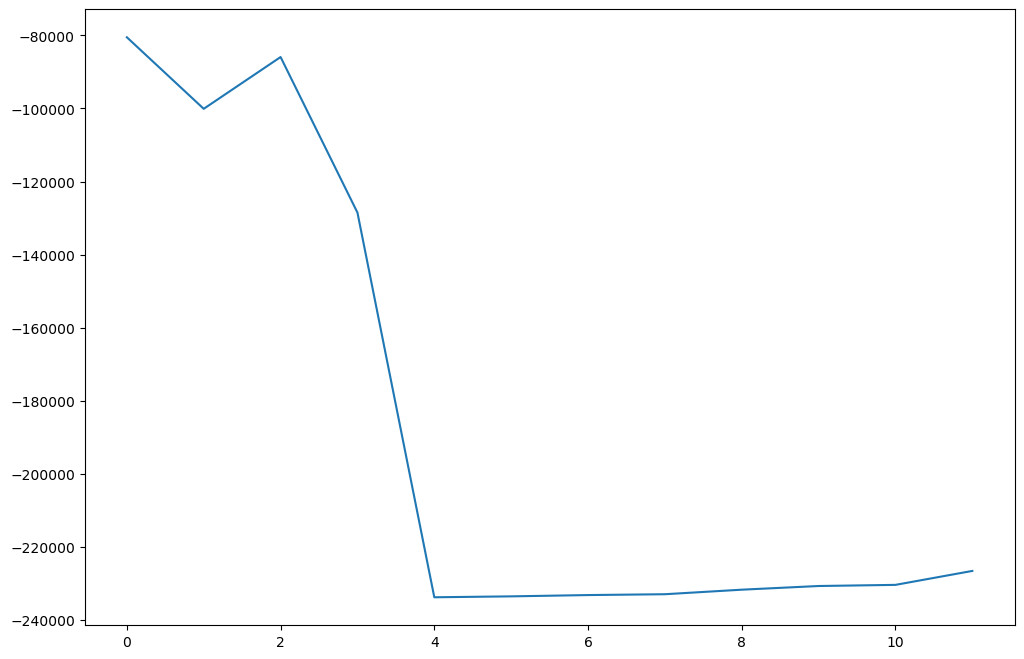

In [25]:
plt.plot(UBICs); plt.show()

In [26]:
from UBIC import *

In [27]:
n_lams = 3
ics, bc, lam = UBICs(best_subsets, 
                     (X_pre, y_pre[:, 1:2]), 
                     u_type='cv', take_sqrt=True, use_baye=True, 
                     delta=1+1/3, n_lams=n_lams)
ics[-n_lams], bc, lam

n_lams = 3
Using baye_uncertainties
[158.85535149 258.75771253 124.57513916  32.35651272   1.
   1.02600143   1.06362583   1.0884958    1.23178153   1.36129565
   1.40364847   2.05389896]
0 ---> 8
1.3333333333333333 ---> 6
2.6666666666666665 ---> 5
4.0 ---> 5
5.333333333333333 ---> 5
[ 473822.03308536  897656.69719111  306892.41629262 -116652.88906709
 -321592.7852043  -321488.21533194 -321333.28686819 -321228.78526099
 -320611.46574409 -320052.44972782 -319865.30952148 -317079.07092362]
The optimal complexity is currently at the support sizes of 5.


(array([ 473822.03308536,  897656.69719111,  306892.41629262,
        -116652.88906709, -321592.7852043 , -321488.21533194,
        -321333.28686819, -321228.78526099, -320611.46574409,
        -320052.44972782, -319865.30952148, -317079.07092362]),
 4,
 2.6666666666666665)

In [28]:
_, _, b_uns = baye_uncertainties(best_subsets, (X_pre, y_pre[:, 1:2]), u_type='cv', take_sqrt=True)
lower_bounds = []
for efi in best_subsets:
    com = len(efi)
    w = np.linalg.lstsq(X_pre[:, efi], y_pre[:, 1:2], rcond=None)[0]
    pred = X_pre[:, efi]@w
    lower_bound = log_like_value(pred, y_pre[:, 1:2])/np.log(len(y_pre[:, 1:2]))-com
    lower_bounds.append(lower_bound)
max_lam = max(np.log10(lower_bounds/b_uns))
delta = np.linspace(0, max_lam, 4)[1]
max_lam

4.247674455990428

In [29]:
n_lams = 3
ics, bc, lam = UBICs(best_subsets, 
                     (X_pre, y_pre[:, 1:2]), 
                     u_type='cv', take_sqrt=True, use_baye=True, 
                     max_lam=max_lam, 
                     delta=delta, 
                     n_lams=n_lams)
ics[-n_lams], bc, lam

n_lams = 3
Using baye_uncertainties
[158.85535149 258.75771253 124.57513916  32.35651272   1.
   1.02600143   1.06362583   1.0884958    1.23178153   1.36129565
   1.40364847   2.05389896]
0 ---> 8
1.4158914853301425 ---> 6
2.831782970660285 ---> 5
4.247674455990428 ---> 5
[ 787960.07394269 1409352.65270575  553240.99559745  -52667.5626646
 -319615.2752375  -319459.28728199 -319229.95618283 -319076.27396736
 -318175.60549507 -317360.47401245 -317089.58067781 -313017.465258  ]
The optimal complexity is currently at the support sizes of 5.


(array([-167172.9175316 , -146452.83771546, -195778.94116253,
        -247214.18952482, -325627.87086299, -325628.21898013,
        -325625.10821244, -325620.95905375, -325581.80972334,
        -325545.39428185, -325529.1513415 , -325366.7291644 ]),
 4,
 2.831782970660285)

In [30]:
lam

2.831782970660285

In [32]:
tau = 3
thres = 0.02

post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre, y_pre[:, 1:2]), u_type='cv1', take_sqrt=True)
preddictions = X_pre@post_means
lower_bounds = []
for k, efi in enumerate(best_subsets):
    com = len(efi)
    lower_bound = log_like_value(preddictions[:, k:k+1], y_pre[:, 1:2])/np.log(len(y_pre[:, 1:2]))-com
    lower_bounds.append(lower_bound)
    
last_lam = np.log10(max(lower_bounds/b_uns))
delta = last_lam/tau
now_lam = max_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(y_pre[:, 1:2]), hyp=10**last_lam)
last_bc = np.argmin(last_ubic)
while now_lam > 0:
    now_ubic = UBIC(b_bics, b_uns, len(y_pre[:, 1:2]), hyp=10**now_lam)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    imp = abs((b_bics[now_bc]-b_bics[last_bc])/(b_bics[last_bc]*diff_com))
    print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), np.nan_to_num(imp, nan=np.inf))
    
    if (diff_com > 0 and imp < thres) or (diff_com < 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = last_lam-delta
    last_ubic = now_ubic
    last_bc = now_bc

last_lam = round(last_lam, 10)
last_lam, last_ubic, last_bc

4 <---> 4 inf
4 <---> 5 2.0216252251847544e-05


(2.8317829707,
 array([ 787960.07394269, 1409352.65270575,  553240.99559745,
         -52667.5626646 , -319615.2752375 , -319459.28728199,
        -319229.95618283, -319076.27396736, -318175.60549507,
        -317360.47401245, -317089.58067781, -313017.465258  ]),
 4)